**Mounting Google Drive for Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

**Importing Libraries**

In [ ]:
import numpy as np
import h5py
import math

from keras.models import Model
from keras.layers import Input, Activation, BatchNormalization, Conv2D, Conv3D
from keras.layers import Lambda, Concatenate, MaxPooling2D, Maximum, Add
from keras.initializers import RandomNormal
from keras.optimizers import SGD
from keras.losses import MeanSquaredError
from keras.callbacks import Callback,LearningRateScheduler
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

**util functions**

In [ ]:
# Load Dataset from Google Drive
def load_train_dataset():
    """
    Load training dataset from Google Drive
    
    Returns:
    clean_image -- Clean image patches
    clean_image -- Hazy image patches
    transmission_value -- Transmission value which convert clean image to 
                          haze image
    """

    file = '/content/drive/My Drive/DL Project/Datasets/TrainData/train_data_patch_16x16_res.hdf5'
    train_dataset = h5py.File(file, 'r')
    clean_image = np.array(train_dataset['clear_image'][:])
    haze_image = np.array(train_dataset['haze_image'][:])
    transmission_map = np.array(train_dataset['transmission_map'])
    transmission_map_refine = np.array(train_dataset['transmission_map_refine'])
    
    return clean_image, haze_image, transmission_map, transmission_map_refine


# Gaussian Weight Initializtion for layers
weight_init = RandomNormal(mean=0.0, stddev=0.001)


# LearningRate Decay function
def lr_schedule(epoch,lr, logs={}):
    """
    Learning Rate Deacy scheduler

    Arguments:
    epoch -- current epoch number
    lr -- current learning rate
    log -- dictionary storing the logs of training

    Returns:
    lr -- learning rate for next epoch
    """
    
    print('learning_rate:',lr)
    logs.update({'lr': lr})
    if epoch in (49,99):
        return lr*0.5
    else:
        return lr

**Preparing Train Dataset**

In [ ]:
clean_image, haze_image, transmission_map, transmission_map_refine = load_train_dataset()

print ("Number of training examples:", clean_image.shape[0])
print ("Clean Image Patch shape:", clean_image.shape)
print ("Haze Image Patch shape:", haze_image.shape)
print ("Transmission Map shape:", haze_image.shape)
print ("Transmission Map Refine shape:", haze_image.shape)

number of training examples: 60000
Clean Image Patch shape: (60000, 16, 16, 3)
Haze Image Patch shape: (60000, 16, 16, 3)
Transmission Map shape: (60000, 16, 16, 3)
Transmission Map Refine shape: (60000, 16, 16, 3)


In [ ]:
residual_input = np.clip(((haze_image/255.0)/np.expand_dims(transmission_map_refine,axis=3)),0,1)
residual_output = np.clip((residual_input-clean_image),0,1)

(0.15836089520286992, 1.0, 0.0, 1.0)

#### Residual Model

**Designing**

In [ ]:
def ResidualBlock(X, iter):
    """
    Implementation of the single block of RNN
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    iter -- integer, used to name layers, depending on current residual block
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Save the input value
    X_shortcut = X
    
    # BATCHNORMALIZATION -> CONV Block
    X = BatchNormalization(axis = 3, name = 'res_batchnorm_' + str(iter))(X)
    X = Conv2D(1, (3, 3), strides = (1,1), padding = 'same', kernel_initializer = weight_init, name = 'res_conv_' + str(iter))(X)

    # Add shortcut value to main path, and pass it through a RELU activation
    X = Add(name = 'res_add_'+ str(iter))([X,X_shortcut])
    X = Activation('relu', name = 'res_activation_'+ str(iter))(X)
    
    return X

def ResidualModel(input_shape):
    """
    Implementation of the Model.
    
    Arguments:
    input_shape -- shape of the images of the dataset 
                   (height, width, channels) as a tuple.  

    Returns:
    model -- a Model() instance in Keras
    """
    
    X_input = Input(input_shape, name = 'input1')

    # CONV -> RELU Block applied to X
    X = Conv2D(16, (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = weight_init, name = 'conv1')(X_input)
    X = Activation('relu', name = 'activation1')(X)

    # X = Conv2D(8, (1, 1), kernel_initializer = weight_init, name='test_conv')(X)

    for i in range(17):
        X = ResidualBlock(X, i)
    
    # CONV BLock
    X = Conv2D(3, (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = weight_init, name = 'conv2')(X)
    X = Activation('relu', name = 'activation2')(X)

    # Create Keras model instance
    model = Model(inputs = X_input, outputs = X, name='TransmissionModel')

    return model

**Compiling**

In [ ]:
model2 = ResidualModel(residual_input.shape[1:])
model2.summary()    
model2.compile(optimizer=SGD(0.001), loss=MeanSquaredError())

Model: "TransmissionModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 16, 16, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 16)   448         input1[0][0]                     
__________________________________________________________________________________________________
activation1 (Activation)        (None, 16, 16, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
res_batchnorm_0 (BatchNormaliza (None, 16, 16, 16)   64          activation1[0][0]                
__________________________________________________________________________________

**Training**

In [ ]:
history2 = model2.fit(residual_input, residual_output, batch_size = 30, epochs = 150, callbacks=[LearningRateScheduler(lr_schedule)])

**Generating Models and Graph**

In [ ]:
plot_model(model2, 'res_model.png')
plot_model(model2, 'res_model_shape.png', True)

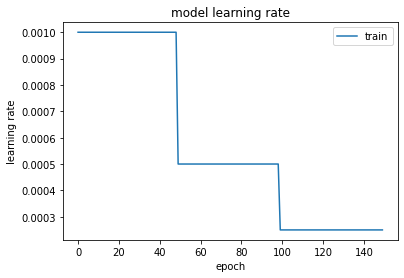

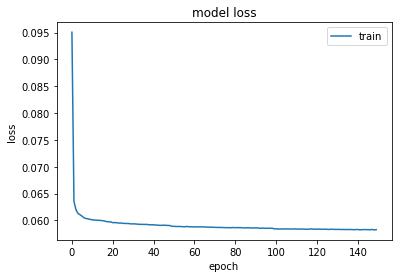

In [ ]:
plt.plot(history2.history['lr'])
plt.title('model learning rate')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.savefig('res150-30-lr.png')
plt.show()
plt.plot(history2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.savefig('res150-30-loss.png')
plt.show()

In [ ]:
model2.save('resmodel_150_30.h5')
model2.save_weights('resmodel_150_30_weights.h5')

**Predicting**

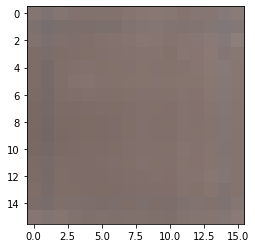

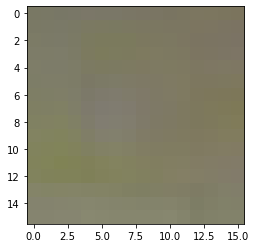

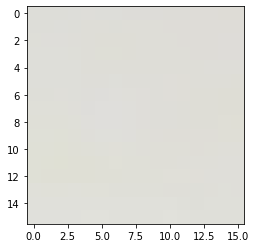

In [ ]:
t = np.expand_dims(residual_input[7], axis=0)
T = model2.predict(t)
plt.imshow(residual_input[7]-T[0])
plt.show()
plt.imshow(clean_image[7])
plt.show()
plt.imshow(haze_image[7])
plt.show()